# Modulation Classification

Developing AutoML Model for AWGN Channel for Modulation Classification. SNR Ratio's(in dB) of Channel are $[5,10,15,20,25,30]$.

**Data Generation:**
Data is generated using MatLab's Communication Toolbox for Modulation Schemes QPSK, 16-QAM, 64-QAM for SNR Ratio's (in dB) $[5,10,15,20,25,30]$ when signal is transmitted through Channels Rician Channels.

**Modulation Classification:**
We will use AutoML to create a Classifier to Predict Labels.

## Imports

### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os

# AutoML Libraries
!pip3 install autokeras
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, ReLU, Conv2D, Input, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.models import Model

     |████████████████████████████████| 174kB 21.7MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=c738ae38c5e814edb69ff2d49a554b9d0583fc658a46327e11aede9d139a798f
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=8535cbefa5424930a8f0a642654925db0955281e096a6d77c2ec4353aa504d2e
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/Real\ Dataset/AutoML

Mounted at /gdrive
/gdrive/My Drive/Modulation-Classification/Real Dataset/AutoML


## Processsing Data

Importing Data for all SNR Ratio's

In [3]:
def ImportData(Path):
    ModulationSchemes = os.listdir(Path)

    Dataset = {}
    for scheme in ModulationSchemes:
        DataPath = Path + "/" + scheme
        files = os.listdir(DataPath)
        DataofScheme = {}
        for f in files:
            Data = scipy.io.loadmat(DataPath + "/" + f)
            snr = Data['snr'][0][0]
            rx = Data['rx']
            DataofScheme[snr] = rx
        Dataset[scheme] = DataofScheme

    return Dataset

## Train and Validation Datasets

**Training:**
- Received Signal with SNR Ratio $30$dB is used for Training for both Channels and all Modulation Schemes.

**Validation:**
- AutoML is validated on Received Signals with SNR Ratio's (in dB) $[5,10,15,20,25]$

In [4]:
def ImportDatasets(Channel):
    if Channel == "Rician":
        Path =  "../Data/" + Channel
    Data = ImportData(Path)
    
    Dataset = {}
    Dataset['Classes'] = list(Data.keys())
    OneHotClasses = np.eye(len(Dataset['Classes']))

    Classes = {}
    for i in range(len(Dataset['Classes'])):
        Classes[Dataset['Classes'][i]] = OneHotClasses[i]

    Valid_SNRs = [5,10,15,20,25]

    if Channel == "Rician":
        X_Train, y_Train = np.empty((0,1,1024,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}
        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,1,1024,2))
            y_Valid[snr] = np.empty((0,3))

        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    return X_Train, y_Train, X_Valid, y_Valid

## Evaluating Data

In [5]:
def EvaluateData(Model, X_Train, y_Train, X_Valid, y_Valid, SavePath, ValidBatchSize=32):
    Valid_SNR = np.array([5,10,15,20,25,30])
    Accuracy = []

    print ("Evaluating Model")
    for snr in Valid_SNR:
        if snr == 30:
            Loss, Acc = Model.evaluate(X_Train, y_Train)
        else:
            Loss, Acc = Model.evaluate(X_Valid[snr], y_Valid[snr], batch_size=ValidBatchSize)
        print ("SNR:", snr, "Accuracy:", Acc)
        Accuracy.append(Acc)

    Accuracy = np.array(Accuracy)

    plt.figure(figsize=(10,10))
    plt.plot(Valid_SNR,Accuracy, color='blue')
    plt.scatter(Valid_SNR,Accuracy, color='red')
    plt.title("Accuracy vs SNR")
    plt.xlabel("SNR")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.savefig(SavePath)
    plt.show()

## AutoML Model for Rician Channel

For Rician Channel, Input Dimensions is (1,1024,2)

#### Rician Data

In [6]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rician')

#### Creating a AutoML Classifier

In [7]:
RicianClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=10,
    loss='categorical_crossentropy',
    tuner='bayesian',
    num_classes=3,
    max_model_size=int(0.75 * 1e8))

RicianClassifier.fit(X_Train, y_Train, epochs=5, batch_size=64, validation_split=0.2,shuffle=True)

Trial 10 Complete [00h 15m 22s]
val_loss: 0.0

Best val_loss So Far: 0.0
Total elapsed time: 02h 32m 07s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
47/47 [==============================] - 30s 471ms/step - loss: 173.7870 - accuracy: 0.8927
Epoch 2/5
47/47 [==============================] - 19s 410ms/step - loss: 3718.1947 - accuracy: 0.5590
Epoch 3/5
47/47 [==============================] - 19s 409ms/step - loss: 17709.2880 - accuracy: 0.5662
Epoch 4/5
47/47 [==============================] - 19s 410ms/step - loss: 5448.7577 - accuracy: 0.4315
Epoch 5/5
47/47 [==============================] - 19s 410ms/step - loss: 2811.7957 - accuracy: 0.5718
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### AutoML Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1024, 2)]      0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 1, 1024, 2)        0         
_________________________________________________________________
normalization (Normalization (None, 1, 1024, 2)        5         
_________________________________________________________________
random_translation (RandomTr (None, 1, 1024, 2)        0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 1, 1024, 2)        0         
_________________________________________________________________
random_contrast (RandomContr (None, 1, 1024, 2)        0         
_________________________________________________________________
resizing (Resizing)          (None, 32, 1024, 2)       0     

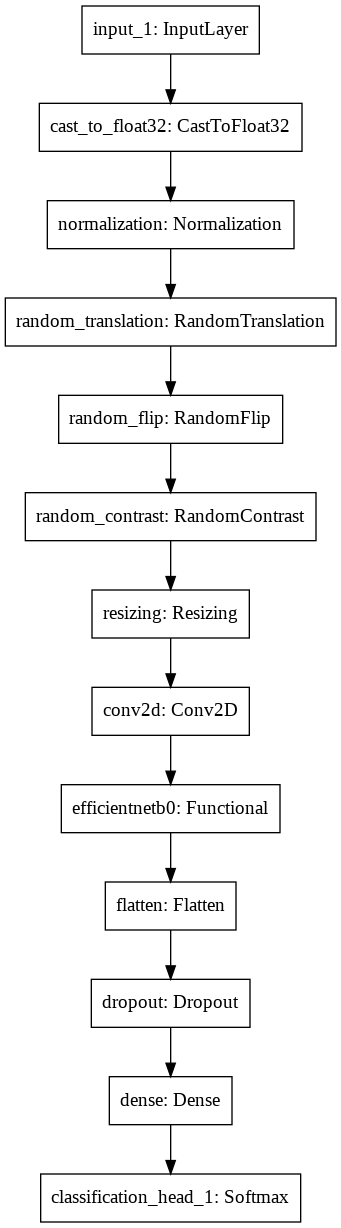

In [8]:
Rician_Model = RicianClassifier.export_model()
Rician_Model.summary()
tf.keras.utils.plot_model(Rician_Model, to_file='../Models/Rician_Model.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating AutoML Model

#### Training the AutoML Model

In [9]:
Rician_Model.fit(X_Train, y_Train, epochs=20, batch_size=64, validation_split=0.2,shuffle=True)

Epoch 1/20
38/38 [==============================] - 31s 597ms/step - loss: 428.7741 - accuracy: 0.3738 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
38/38 [==============================] - 16s 426ms/step - loss: 101.8930 - accuracy: 0.3775 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
38/38 [==============================] - 16s 428ms/step - loss: 64.4885 - accuracy: 0.3708 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
38/38 [==============================] - 16s 423ms/step - loss: 49.6935 - accuracy: 0.3658 - val_loss: 301.7932 - val_accuracy: 0.3883
Epoch 5/20
38/38 [==============================] - 16s 420ms/step - loss: 40.0065 - accuracy: 0.3887 - val_loss: 54.4407 - val_accuracy: 0.0433
Epoch 6/20
38/38 [==============================] - 16s 421ms/step - loss: 41.9208 - accuracy: 0.3733 - val_loss: 118.2899 - val_accuracy: 0.0000e+00
Epoch 7/20
38/38 [==============================] - 16s 427ms/step - loss: 44.8507 - accuracy: 0.3738 - val_loss:

#### Evaluate the AutoML Model

Evaluating Model
94/94 [==============================] - 4s 40ms/step - loss: 18.3191 - accuracy: 0.3327
SNR: 5 Accuracy: 0.33266666531562805
94/94 [==============================] - 4s 40ms/step - loss: 19.0670 - accuracy: 0.3257
SNR: 10 Accuracy: 0.3256666660308838
94/94 [==============================] - 4s 40ms/step - loss: 18.6686 - accuracy: 0.3150
SNR: 15 Accuracy: 0.3149999976158142
94/94 [==============================] - 4s 40ms/step - loss: 17.4295 - accuracy: 0.3073
SNR: 20 Accuracy: 0.3073333203792572
94/94 [==============================] - 4s 40ms/step - loss: 16.9965 - accuracy: 0.2870
SNR: 25 Accuracy: 0.28700000047683716
94/94 [==============================] - 4s 40ms/step - loss: 16.9488 - accuracy: 0.2817
SNR: 30 Accuracy: 0.28166666626930237


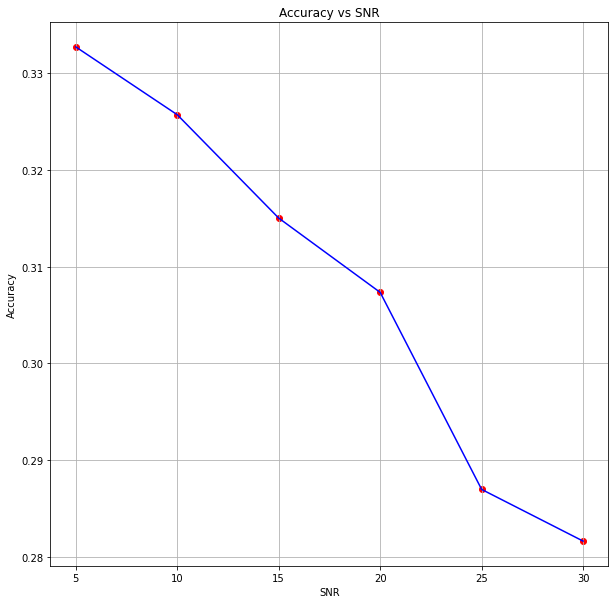

In [10]:
EvaluateData(Rician_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rician_Model_Accuracy.jpg")

#### Save AutoML Model

In [11]:
Rician_Model.save("../Models/Rician_Model.h5")

## CNN Model for Rician Channel

### Rician Data
For Rician Channel, Input Dimensions is (1,1024,2)

In [12]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rician')

### Creating a CNN Classifier

In [13]:
tf.keras.backend.clear_session()

Inp = Input(shape=(1,1024,2))

x = Conv2D(filters=16, kernel_size=(1,8),padding='same')(Inp)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(1,2),strides=(1,2))(x)

x = Conv2D(filters=24, kernel_size=(1,8),padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(1,2),strides=(1,2))(x)

x = Conv2D(filters=32, kernel_size=(1,8),padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(1,2),strides=(1,2))(x)

x = Conv2D(filters=48, kernel_size=(1,8),padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(1,2),strides=(1,2))(x)

x = Conv2D(filters=64, kernel_size=(1,8),padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(1,2),strides=(1,2))(x)

x = Conv2D(filters=96, kernel_size=(1,8),padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = AveragePooling2D(pool_size=(1,32))(x)

x = Flatten()(x)
Out = Dense(3,activation='softmax')(x)

CNNModel = Model(Inp,Out)

### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1024, 2)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1024, 16)       272       
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 1024, 16)       64        
_________________________________________________________________
re_lu (ReLU)                 (None, 1, 1024, 16)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 512, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 512, 24)        3096      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 512, 24)        96    

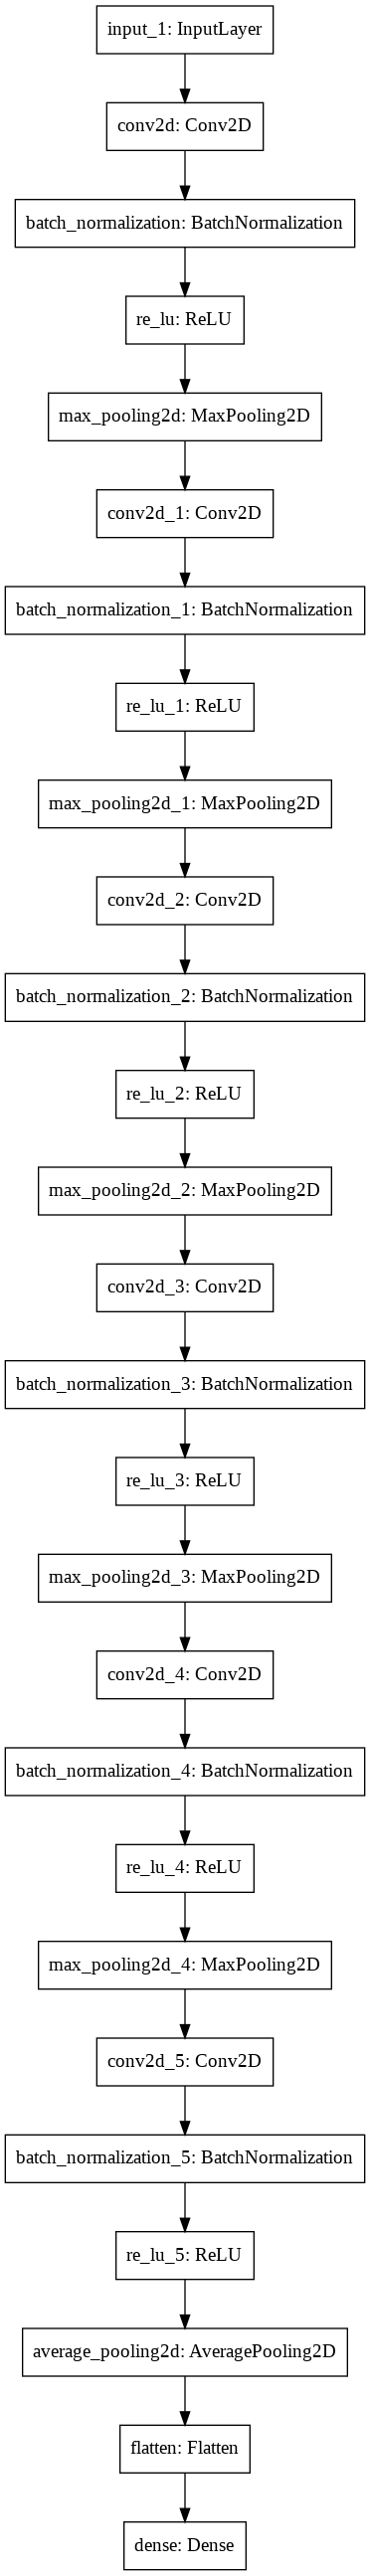

In [14]:
CNNModel.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])
CNNModel.summary()
tf.keras.utils.plot_model(CNNModel, to_file='../Models/CNNModel.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [15]:
CNNModel.fit(X_Train,y_Train,batch_size=256,epochs=100,validation_split=0.2,shuffle=True)


Epoch 1/100
10/10 [==============================] - 3s 171ms/step - loss: 1.2079 - accuracy: 0.4165 - val_loss: 1.2040 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 19ms/step - loss: 0.8458 - accuracy: 0.5528 - val_loss: 0.8397 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 0s 19ms/step - loss: 0.6836 - accuracy: 0.6682 - val_loss: 0.3685 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 0s 19ms/step - loss: 0.6078 - accuracy: 0.7169 - val_loss: 0.1273 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 0s 19ms/step - loss: 0.5524 - accuracy: 0.7545 - val_loss: 0.0489 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 0s 18ms/step - loss: 0.4991 - accuracy: 0.8028 - val_loss: 0.0215 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 0s 19ms/step - loss: 0.4213 - accuracy: 0.8603 - val_loss: 0.0096 - val_accuracy: 1.0000
E

#### Evaluating the CNN Model

Evaluating Model
94/94 [==============================] - 1s 4ms/step - loss: 10.9314 - accuracy: 0.3367
SNR: 5 Accuracy: 0.33666667342185974
94/94 [==============================] - 0s 3ms/step - loss: 5.8266 - accuracy: 0.4063
SNR: 10 Accuracy: 0.406333327293396
94/94 [==============================] - 0s 3ms/step - loss: 2.6862 - accuracy: 0.5133
SNR: 15 Accuracy: 0.5133333206176758
94/94 [==============================] - 0s 3ms/step - loss: 1.5724 - accuracy: 0.5873
SNR: 20 Accuracy: 0.5873333215713501
94/94 [==============================] - 0s 3ms/step - loss: 1.2179 - accuracy: 0.6503
SNR: 25 Accuracy: 0.6503333449363708
94/94 [==============================] - 0s 3ms/step - loss: 0.0520 - accuracy: 0.9870
SNR: 30 Accuracy: 0.9869999885559082


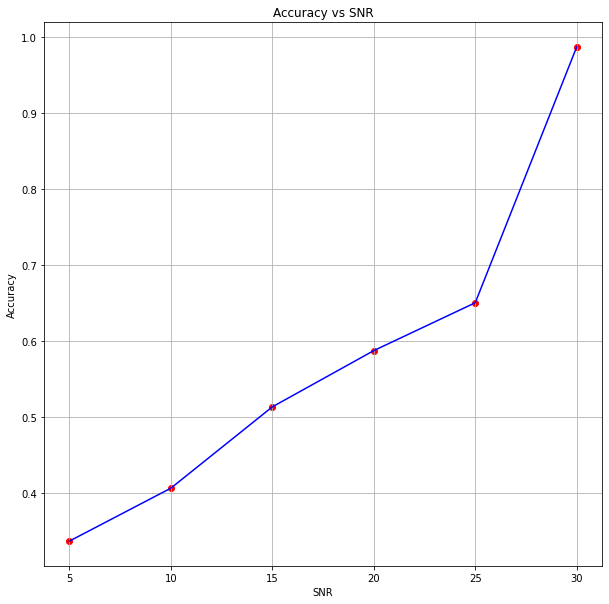

In [16]:
EvaluateData(CNNModel, X_Train, y_Train, X_Valid, y_Valid, "../Results/CNNModel_Accuracy.jpg")

#### Save CNN Model

In [17]:
CNNModel.save("../Models/CNNModel.h5")